**2023 Samsung AI Challenge : Camera-Invariant Domain Adaptation**

- 사용 환경 : Colab Pro Plus

- OS : Ubuntu 22.04.2 LTS

- GPU : A100 40GB

- Cuda 버전 : 11.8

- Python 버전 : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

- 라이브러리 버전
    - numpy: 1.23.5
    - matplotlib: 3.7.1
    - pandas: 1.5.3
    - tqdm: 4.66.1
    - torch: 2.0.1
    - torchvision: 0.15.2
    - albumentations: 1.3.1
    - cv2: 4.8.0
    - timm: 0.9.7
    - huggingface-hub: 0.17.3
    - safetensors: 0.3.3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

#라이브러리


In [ ]:
!pip install timm

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2, glob,  time, json ,os,tqdm,random,math, shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.vision_transformer import _cfg

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
from content.Deeplabv3 import network

In [ ]:
!git clone https://github.com/VainF/DeepLabV3Plus-Pytorch.git /content/Deeplabv3
from Deeplabv3 import network

# 데이터 폴더 복사

In [ ]:
# Colab에서 장기간 학습 시 Google Drive 연결이 잠깐 끊겨 학습이 중단되는 현상이 발생해 Colab 로컬 드라이브에 복사해두어 학습 진행
# Colab 환경이 아닌 경우 root_path 와 data_path를 동일한 값으로 설정하고 이 코드만 실행해도 됨

#기본 경로설정
root_path = '/content/drive/MyDrive/samsung_seg(512,1024)'
data_path = '/content/samsung_seg(512,1024)'

In [ ]:

if os.path.exists(data_path):
    shutil.rmtree(data_path)

listdir = ['train_source_image',
           'train_source_gt',
           'train_target_image',
           'val_source_gt',
           'val_source_image',
           'test_image']

#listdir = ['test_image'] #추론만 할 경우

for dir in tqdm.tqdm(listdir):
    shutil.copytree(f'{root_path}/{dir}',f'{data_path}/{dir}')

100%|██████████| 1/1 [01:27<00:00, 87.76s/it]


# 데이터 시각화 설정

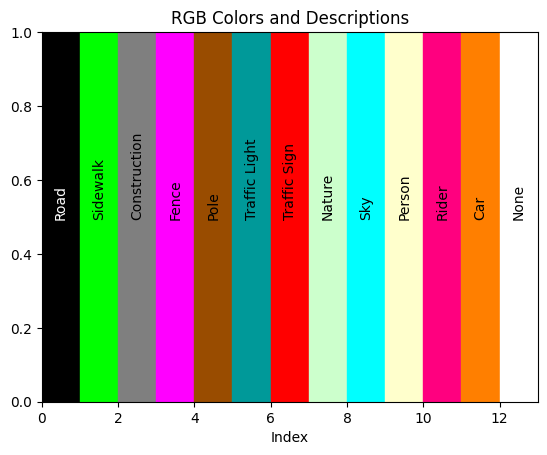

In [7]:
# 이미지를 정규화된 상태에서 역정규화하는 함수를 정의합니다.
def denormalization(img, source=True):
    if source:
        # source 매개변수가 True이면, source_mean과 source_std 값을 사용합니다.
        mean = source_mean
        std = source_std
    else:
        # source 매개변수가 False이면, target_mean과 target_std 값을 사용합니다.
        mean = target_mean
        std = target_std

    # 이미지를 역정규화합니다.
    out_img = img * std + mean
    return out_img

# 색상 팔레트 및 클래스 이름을 정의합니다.
palette = [[0, 0, 0], [0, 255, 0], [127, 127, 127], [255, 0, 255], [153, 76, 0], [0, 153, 153], [255, 0, 0], [204, 255, 204], [0, 255, 255], [255, 255, 204], [255, 0, 127], [255, 127, 0], [255, 255, 255]]
cls_name = ['Road', 'Sidewalk', 'Construction', 'Fence', 'Pole', 'Traffic Light', 'Traffic Sign', 'Nature', 'Sky', 'Person', 'Rider', 'Car', 'None']

# 팔레트의 각 색상 및 클래스 이름을 순회하면서 시각적으로 표시합니다.
indices = list(range(len(palette)))

# matplotlib을 사용하여 RGB 값을 가지고 색상을 생성하고 영역을 채웁니다.
for i, (rgb, label) in enumerate(zip(palette, cls_name)):
    r, g, b = [x / 255 for x in rgb]  # RGB 값을 0에서 1 범위로 정규화합니다.
    color = (r, g, b)  # 정규화된 RGB 값을 color 변수에 저장합니다.
    plt.fill_between([i, i + 1], 0, 1, color=color)  # 현재 색상으로 영역을 채웁니다.

    # 첫 번째 항목 (인덱스 0)인 경우 텍스트 색상을 흰색으로, 그 외에는 검은색으로 설정합니다.
    if i == 0:
        c = "white"
    else:
        c = "black"

    # 클래스 이름을 중앙 정렬하여 현재 색상 아래에 표시합니다.
    plt.text(i + 0.5, 0.5, label, ha='center', rotation=90, color=c)

# x와 y 축의 범위, 레이블 및 제목을 설정하여 그래프를 보여줍니다.
plt.xlim(0, len(palette))
plt.ylim(0, 1)
plt.xlabel('Index')  # x 축 레이블 설정
plt.title('RGB Colors and Descriptions')  # 그래프 제목 설정
plt.show()  # 그래프를 화면에 표시합니다.


# 데이터로더 정의

In [ ]:
#사전에 미리 Resize해둔 이미지 크기
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 512

#Crop한 이미지의 크기
CROP_WIDTH = IMAGE_WIDTH//2
CROP_HEIGHT = IMAGE_HEIGHT//2

In [ ]:
#Train_Source + Valid_Source 의 Mean, Std
source_mean = [0.5897106 , 0.5952661 , 0.57897425]
source_std = [0.16688786, 0.15721062, 0.1589595]

#Train_Target 의 Mean, Std
target_mean = [0.4714665 , 0.47141412, 0.49733913]
target_std = [0.23908237, 0.24033973, 0.25281718]

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, csv_file, target_csv_file=None, mix_bg_prob = 0, infer=False):

#         #여러 csv 파일 합치기
#         if type(csv_file) == list:
#             self.data = pd.read_csv(csv_file[0])
#             for i in range(1,len(csv_file)):
#                 self.data = pd.concat([self.data, pd.read_csv(csv_file[i])], ignore_index=True)
#         else :
#             self.data = pd.read_csv(csv_file)

#         self.infer = infer

#         self.mix_bg_prob = mix_bg_prob

#         #공통으로 적용되는 Transform

#         self.augmentation = A.Compose([
#                 A.ColorJitter(p=0.25),
#                 A.HorizontalFlip(p=0.5),
#                 A.RandomCrop(width = CROP_WIDTH, height = CROP_HEIGHT)
#             ])

#         self.source_norm = A.Normalize(mean = source_mean , std = source_std)
#         self.target_norm = A.Normalize(mean = target_mean , std = target_std)

#         self.len_source = len(self.data)

#         if target_csv_file :
#             self.target_data = pd.read_csv(target_csv_file)
#             self.len_target = len(self.target_data)

#         else :
#             self.target_data = None
#             self.len_target = 1

#     def mix_bg(self,source_image,source_mask,target_image):

#         h,w,c = source_image.shape

#         # 타원의 중심 좌표와 크기 설정 (예: 중심 (x, y), 장축 반지름 a, 단축 반지름 b)
#         center = (IMAGE_WIDTH//2, int(IMAGE_HEIGHT*0.375))  # x,y
#         axis_length = (IMAGE_WIDTH//2, int(IMAGE_HEIGHT*0.64))  # 장축 반지름과 단축 반지름

#         # 타원 그리기 (타원을 1로 채우고 나머지 부분은 0으로 채움)
#         mask = np.zeros((h,w,1),dtype=np.uint8)
#         cv2.ellipse(mask, center, axis_length, 0, 0, 360, 1, -1)

#         # 타원 모양으로 crop된 이미지 생성
#         mixed_image = source_image * mask + target_image * (1-mask)
#         mixed_mask = source_mask * mask[:,:,0] + np.ones_like(source_mask)*12*(1-mask[:,:,0])

#         return mixed_image, mixed_mask

#     def __len__(self):
#         return self.len_source

#     def __getitem__(self, idx):
#         source_idx = idx

#         img_path = self.data.iloc[source_idx, 1].replace('./',data_path+'/')
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



#         if self.infer == True:
#             image = A.Compose([self.target_norm,
#                                ToTensorV2()])(image=image)['image']
#             return image


#         mask_path = self.data.iloc[source_idx, 2].replace('./',data_path+'/')
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         mask[mask == 255] = 12

#         # 보닛 부분에 있는 하늘 클래스들을 배경클래스로 변환
#         mask[IMAGE_HEIGHT//3*2:][mask[IMAGE_HEIGHT//3*2:]==8] = 12

#         target_image = np.zeros_like(image) 
#         distortion_image = image.copy()
#         distortion_mask = mask.copy()

#         if self.target_data is not None:
#             target_img_path = self.target_data.iloc[idx % self.len_target, 1].replace('./',data_path+'/')
#             target_image = cv2.imread(target_img_path)
#             target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

#             if self.mix_bg_prob > np.random.uniform(0,1):
#                 distortion_image,distortion_mask = self.mix_bg(distortion_image.astype(np.uint8),distortion_mask.astype(np.uint8),target_image)

#         source_tensor = A.Compose([self.augmentation,
#                                    self.source_norm,
#                                    ToTensorV2()])(image=image,mask=mask)

#         target_image = A.Compose([self.augmentation,
#                                   self.target_norm,
#                                   ToTensorV2()])(image=target_image)['image']

#         distortion_tensor = A.Compose([self.augmentation,
#                                     A.ElasticTransform(alpha=100, sigma=10, alpha_affine=25,border_mode = 1,p=1),
#                                     self.source_norm,
#                                     ToTensorV2()])(image=distortion_image,mask= distortion_mask)

#         image = source_tensor['image']
#         mask = source_tensor['mask']
#         distortion_image = distortion_tensor['image']
#         distortion_mask = distortion_tensor['mask']


#         return image, mask, target_image, distortion_image, distortion_mask

In [ ]:
# PyTorch의 Dataset 클래스를 상속하여 사용자 정의 데이터셋을 생성합니다.
class CustomDataset(Dataset):
    def __init__(self, csv_file, target_csv_file=None, mix_bg_prob=0, infer=False):

        # 여러 CSV 파일을 병합합니다.
        if type(csv_file) == list:
            self.data = pd.read_csv(csv_file[0])
            for i in range(1, len(csv_file)):
                self.data = pd.concat([self.data, pd.read_csv(csv_file[i])], ignore_index=True)
        else:
            self.data = pd.read_csv(csv_file)

        self.infer = infer

        self.mix_bg_prob = mix_bg_prob

        # 공통으로 적용되는 데이터 변환을 설정합니다.
        self.augmentation = A.Compose([
            A.ColorJitter(p=0.25),
            A.HorizontalFlip(p=0.5),
            A.RandomCrop(width=CROP_WIDTH, height=CROP_HEIGHT)
        ])

        self.source_norm = A.Normalize(mean=source_mean, std=source_std)
        self.target_norm = A.Normalize(mean=target_mean, std=target_std)

        self.len_source = len(self.data)

        if target_csv_file:
            self.target_data = pd.read_csv(target_csv_file)
            self.len_target = len(self.target_data)
        else:
            self.target_data = None
            self.len_target = 1

    # 배경 이미지와 원본 이미지를 혼합하는 메소드
    def mix_bg(self, source_image, source_mask, target_image):
        # 소스 이미지의 높이, 너비, 채널 수를 가져옵니다.
        h, w, c = source_image.shape

        # 타원 모양의 마스크를 생성합니다.
        # 타원은 중심 좌표와 장축, 단축 반지름 정보를 사용하여 정의됩니다.
        center = (IMAGE_WIDTH // 2, int(IMAGE_HEIGHT * 0.375))  # 타원 중심 좌표 (x, y)
        axis_length = (IMAGE_WIDTH // 2, int(IMAGE_HEIGHT * 0.64))  # 장축 반지름과 단축 반지름

        # 마스크를 초기화하고 타원을 그려 마스크를 생성합니다.
        mask = np.zeros((h, w, 1), dtype=np.uint8)
        cv2.ellipse(mask, center, axis_length, 0, 0, 360, 1, -1)

        # 타원 모양으로 이미지를 혼합합니다.
        # 타원 내부는 source_image로, 타원 외부는 target_image로 혼합합니다.
        mixed_image = source_image * mask + target_image * (1 - mask)

        # 마스크도 혼합하여 새로운 마스크를 생성합니다.
        # 타원 내부는 source_mask로, 타원 외부는 클래스 12로 (또는 다른 값으로) 설정합니다.
        mixed_mask = source_mask * mask[:, :, 0] + np.ones_like(source_mask) * 12 * (1 - mask[:, :, 0])

        # 혼합된 이미지와 마스크를 반환합니다.
        return mixed_image, mixed_mask

    def __len__(self):
        return self.len_source

    def __getitem__(self, idx):
        source_idx = idx

        # 이미지와 마스크 파일 경로 설정
        img_path = self.data.iloc[source_idx, 1].replace('./', data_path + '/')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer == True:
            # 추론 모드에서 이미지를 정규화하고 PyTorch Tensor로 변환
            image = A.Compose([self.target_norm, ToTensorV2()])(image=image)['image']
            return image

        mask_path = self.data.iloc[source_idx, 2].replace('./', data_path + '/')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 12

        # 이미지의 하늘 부분을 배경 클래스로 변환
        mask[IMAGE_HEIGHT // 3 * 2:][mask[IMAGE_HEIGHT // 3 * 2:] == 8] = 12

        #image와 동일한 크기와 형태를 가지지만 값은 모두 0으로 초기화
        target_image = np.zeros_like(image)
        distortion_image = image.copy()
        distortion_mask = mask.copy()

        # self.target_data가 존재하는 경우에만 실행
        if self.target_data is not None:
            # 대상 이미지 파일 경로 설정
            # idx % self.len_target를 사용하여 대상 데이터에서 이미지 선택
            target_img_path = self.target_data.iloc[idx % self.len_target, 1].replace('./', data_path + '/')
            
            # 대상 이미지를 읽어옵니다.
            target_image = cv2.imread(target_img_path)
            
            # 대상 이미지의 색상 체계를 BGR에서 RGB로 변환합니다.
            target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

            # mix_bg_prob 확률로 이미지 혼합 작업 수행
            if self.mix_bg_prob > np.random.uniform(0, 1):
                # 이미지 혼합을 수행할 때 distortion_image와 distortion_mask는 이미 초기화되어 있어야 합니다.
                distortion_image, distortion_mask = self.mix_bg(distortion_image.astype(np.uint8),
                                                                distortion_mask.astype(np.uint8), target_image)


        # 데이터 변환 수행
        source_tensor = A.Compose([self.augmentation, self.source_norm, ToTensorV2()])(image=image, mask=mask)
        target_image = A.Compose([self.augmentation, self.target_norm, ToTensorV2()])(image=target_image)['image']
        distortion_tensor = A.Compose([self.augmentation,
                                       A.ElasticTransform(alpha=100, sigma=10, alpha_affine=25, border_mode=1, p=1),
                                       self.source_norm, ToTensorV2()])(image=distortion_image, mask=distortion_mask)

        image = source_tensor['image']
        mask = source_tensor['mask']
        distortion_image = distortion_tensor['image']
        distortion_mask = distortion_tensor['mask']

        return image, mask, target_image, distortion_image, distortion_mask


# 데이터 증강, 로더 테스트

In [ ]:

train_set = CustomDataset(csv_file=[f'{root_path}/train_source.csv', f'{root_path}/val_source.csv', f'{root_path}/val_source.csv'],
                          target_csv_file = f'{root_path}/train_target.csv',
                          mix_bg_prob = 0.25)
valid_set = CustomDataset(csv_file=f'{root_path}/val_source.csv' ) #실제로 사용하지는 않음, 1/10의 데이터를 사용하여도 100에폭까지 오버피팅이 발생하지 않았음

print(len(train_set))
print(train_set.len_source)
print(train_set.len_target)

3126
3126
2923


In [9]:
# 이미지 인덱스 2660에서 2669까지 반복
for i in range(2660, 2670):
    # 현재 시간 측정
    start_time = time.time()

    # train_set.__getitem__(i)을 통해 이미지, 마스크 및 기타 데이터를 가져옵니다.
    img, mask, target_img, distortion_img, distortion_mask = train_set.__getitem__(i)
    
    # 처리 시간 출력
    print(time.time() - start_time)

    # 이미지 및 대상 이미지를 밀어내기 및 밀어내기 반전 작업 수행
    img = (denormalization(np.transpose(img, (1, 2, 0)).numpy()) * 255).astype(np.uint8)
    target_img = (denormalization(np.transpose(target_img, (1, 2, 0)).numpy(), False) * 255).astype(np.uint8)
    distortion_img = (denormalization(np.transpose(distortion_img, (1, 2, 0)).numpy()) * 255).astype(np.uint8)
    print(target_img.min(), target_img.max(), target_img.shape)

    # color_mask 및 color_distortion_mask 초기화
    color_mask = np.zeros_like(img, dtype=np.uint8)
    color_distortion_mask = np.zeros_like(img, dtype=np.uint8)

    # 각 클래스에 대해 color_mask 및 color_distortion_mask 업데이트
    for j, color in enumerate(palette):
        color_mask[mask == j] = color
        color_distortion_mask[distortion_mask == j] = color

    # 이미지 및 결과를 시각화하기 위한 플롯 생성
    plt.figure(figsize=(30, 15))
    
    # 원본 이미지
    plt.subplot(1, 6, 1)
    plt.imshow(img)

    # 클래스에 따라 색칠된 마스크 이미지
    plt.subplot(1, 6, 2)
    plt.imshow(color_mask)

    # 원본 이미지와 색칠된 마스크 이미지를 중간 비중으로 혼합
    plt.subplot(1, 6, 3)
    plt.imshow(cv2.addWeighted(img, 0.5, color_mask, 0.5, 0))

    # 대상 이미지
    plt.subplot(1, 6, 4)
    plt.imshow(target_img)

    # 왜곡된 이미지
    plt.subplot(1, 6, 5)
    plt.imshow(distortion_img)

    # 왜곡된 이미지와 색칠된 왜곡 마스크 이미지를 중간 비중으로 혼합
    plt.subplot(1, 6, 6)
    plt.imshow(cv2.addWeighted(distortion_img, 0.5, color_distortion_mask, 0.5, 0))

    # 플롯 표시
    plt.show()


NameError: name 'train_set' is not defined

#모델 선언


##DAFormer


### MiT

In [ ]:



class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x



class mit_b0(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b1(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b2(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b3(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b4(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b5(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

### DAFormer Head

In [ ]:
class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

class Context_Aware_Fusion(nn.Module):
    def __init__(self, input_dim=1024, embed_dim=256,dilations=[1,6,12,18]):
        super(Context_Aware_Fusion,self).__init__()


        self.proj = nn.Linear(input_dim, embed_dim)

        self.aspp = nn.ModuleList()

        self.dilations = dilations
        for dilation in self.dilations:
            if dilation == 1:
                self.aspp.append(
                    nn.Sequential(
                            nn.Conv2d(input_dim,embed_dim,1,1),
                            nn.BatchNorm2d(embed_dim),
                            nn.ReLU()
                        )
                    )
            else:
                self.aspp.append(
                    nn.Sequential(
                            nn.Conv2d(input_dim,input_dim,3,1,dilation,dilation,input_dim),
                            nn.Conv2d(input_dim,embed_dim,1,1),
                            nn.BatchNorm2d(embed_dim),
                            nn.ReLU()
                        )
                    )

        self.bottleneck = nn.Conv2d(input_dim,embed_dim,1)

    def forward(self, x):

        cat_list = []
        for i in range(len(self.dilations)):
            cat_list.append(self.aspp[i](x))

        out = torch.cat(cat_list,1)

        out = self.bottleneck(out)
        return out


class daformerhead(nn.Module):

    def __init__(self,embed_dim = 256):
        super(daformerhead,self).__init__()
        self.linear_c1 = MLP(64,embed_dim)
        self.linear_c2 = MLP(128,embed_dim)
        self.linear_c3 = MLP(320,embed_dim)
        self.linear_c4 = MLP(512,embed_dim)


        self.cls_head = nn.Sequential(
            nn.Dropout2d(0.1),
            nn.Conv2d(embed_dim,13,1,1)
        )
        self.fuse_layer = Context_Aware_Fusion(embed_dim*4,embed_dim,[1,6,12,18])


    def forward(self,x):
        c1, c2, c3, c4 = x  # len=4, 1/4,1/8,1/16,1/32

        n, _, h, w = c4.shape



        _c4 = self.linear_c4(c4).permute(0,2,1).reshape(n, -1, c4.shape[2], c4.shape[3])
        _c4 = F.interpolate(_c4, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c3 = self.linear_c3(c3).permute(0,2,1).reshape(n, -1, c3.shape[2], c3.shape[3])
        _c3 = F.interpolate(_c3, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c2 = self.linear_c2(c2).permute(0,2,1).reshape(n, -1, c2.shape[2], c2.shape[3])
        _c2 = F.interpolate(_c2, size=c1.size()[2:],mode='bilinear',align_corners=False)


        _c1 = self.linear_c1(c1).permute(0,2,1).reshape(n, -1, c1.shape[2], c1.shape[3])

        out = self.fuse_layer(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        out = self.cls_head(F.interpolate(out, size=(CROP_HEIGHT,CROP_WIDTH),mode='bilinear',align_corners=False))


        return out

### Model

In [ ]:
class daformer(nn.Module):
    def __init__(self,backbone,head):
        super(daformer,self).__init__()
        self.backbone = backbone
        self.classifier = head

    def forward(self,x):
        out = {}
        out['features'] = self.backbone(x)
        out['out'] = self.classifier(out['features'])

        return out

##UNET


In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )
class UNet(nn.Module):
    def __init__(self,backbone,last=512):
        super(UNet, self).__init__()

        self.backbone = nn.ModuleList()

        tmp = []

        for i in range(28):
            if (i+1)%7==0:
                self.backbone.append(nn.Sequential(*tmp))
                tmp =  [backbone.features[i]]
                pass
            else:
                tmp.append(backbone.features[i])


        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)


        self.classifier = nn.ModuleList()

        self.classifier.append(double_conv(last//2 + last, last//2))
        self.classifier.append(double_conv(last//4 + last//2, last//4))
        self.classifier.append(double_conv(last//8 + last//4, last//8))
        self.classifier.append(nn.Conv2d(last//8, 13, 1))

    def forward(self,x):


        layer1 = self.backbone[0](x)

        layer2 = self.backbone[1](layer1)
        layer3 = self.backbone[2](layer2)

        layer4 = self.backbone[3](layer3)

        out = {}

        out['feature'] = layer4

        x = self.upsample(layer4)
        x = torch.cat([x, layer3], dim=1)

        x = self.classifier[0](x)
        x = self.upsample(x)
        x = torch.cat([x, layer2], dim=1)

        x = self.classifier[1](x)
        x = self.upsample(x)
        x = torch.cat([x, layer1], dim=1)

        x = self.classifier[2](x)


        out['out'] = self.classifier[3](x)


        return out



In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )
class ResUNet(nn.Module):
    def __init__(self,backbone,last=512):
        super(ResUNet, self).__init__()

        self.backbone = nn.ModuleList()

        self.backbone.append(
            nn.Sequential(
                backbone.conv1,
                backbone.bn1,
                backbone.relu
            ))
        self.backbone.append(backbone.layer1)
        self.backbone.append(backbone.layer2)
        self.backbone.append(backbone.layer3)
        self.backbone.append(backbone.layer4)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)


        self.classifier = nn.ModuleList()

        self.classifier.append(double_conv(last//2 + last, last//2))
        self.classifier.append(double_conv(last//4 + last//2, last//4))
        self.classifier.append(double_conv(last//8 + last//4, last//8))
        self.classifier.append(nn.Conv2d(last//8, 13, 1))

    def forward(self,x):

        stem = self.backbone[0](x)

        layer1 = self.backbone[1](stem)

        layer2 = self.backbone[2](layer1)
        layer3 = self.backbone[3](layer2)

        layer4 = self.backbone[4](layer3)

        out = {}

        out['feature'] = layer4

        x = self.upsample(layer4)
        x = torch.cat([x, layer3], dim=1)

        x = self.classifier[0](x)
        x = self.upsample(x)
        x = torch.cat([x, layer2], dim=1)

        x = self.classifier[1](x)
        x = self.upsample(x)
        x = torch.cat([x, layer1], dim=1)

        x = self.classifier[2](x)


        out['out'] = self.upsample(self.classifier[3](x))


        return out



##DeepLab

In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, n_classes=21,paddings=[6,12,18,24], dilations=[6,12,18,24]):
        super(ASPP, self).__init__()

        self.branch = nn.ModuleList()

        for p,d in zip(paddings, dilations):
            self.branch.append(nn.Conv2d(in_channels, n_classes, kernel_size=3, stride=1, padding=p, dilation=d))

    def forward(self, x):
        branchs = []

        for b in self.branch:
            branchs.append(b(x))


        out = sum(branchs)

        return out



class deeplabv2(nn.Module):
    def __init__(self,backbone):
        super(deeplabv2,self).__init__()
        self.backbone = backbone
        self.classifier = ASPP(2048, 13)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.distortion = nn.Linear(2048,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = {}

        b,c,h,w = x.shape

        out['feature'] = self.backbone(x)['out']
        out['out'] = F.interpolate(self.classifier(out['feature']), size=x.shape[2:], mode="bilinear", align_corners=False)

        out['distortion'] = self.sigmoid(self.distortion(self.avg_pool(out['feature']).view(b,-1)))

        return out





# 함수 설정

## 평가지표

In [ ]:
def accuracy(pred, label):
    with torch.no_grad():

        b,c,h,w = pred.shape

        _,pred = torch.max(pred, dim=1)
        accuracy = torch.sum(pred==label)/(b*h*w)
    return accuracy

def miou(pred,label):
    with torch.no_grad():
        _,pred = torch.max(pred, dim=1)
        intersection = torch.sum(((pred<12) & (pred==label)))
        union = torch.sum((pred<12)|(label<12))


        iou = intersection / (union+1e-9)

    return iou


## Target Loss


In [ ]:
class target_loss(nn.Module):
    def __init__(self, t=0.968):
        # 클래스 초기화: 임계값 t를 설정하고 Cross Entropy Loss 함수를 초기화
        super(target_loss, self).__init__()
        self.t = t
        self.celoss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, pred, pseudo_label):
        b, c, h, w = pseudo_label.shape

        # pseudo_label에서 최대값을 찾아 신뢰도와 해당 위치(pt)를 추출
        confidence, pt = torch.max(pseudo_label, dim=1)  # b, h, w

        # 신뢰도가 t보다 큰 픽셀의 비율(qt)을 계산
        qt = (torch.sum(confidence.view(b, -1) > self.t, 1) / (h * w)).view(b, 1, 1)  # b, 1, 1

        # 손실 계산: Cross Entropy Loss에 가중치(qt)를 곱하여 계산
        loss = torch.mean(self.celoss(pred, pt) * qt)  # b, h, w * b, 1, 1 -> b, h, w -> 1

        # 계산된 손실 반환
        return loss


## DACS
DACS 기법 : 이미지별 일부 클래스 섞기 ( 학습 에폭이 큰 경우에만 잘 작동하는 것으로 보이기에 삭제 )

In [ ]:
def dacs(xs, ys, xt, yt, ratio=0.25):
    # 입력 데이터 크기를 가져와서 변수 b(배치 크기)와 c(클래스 수)를 초기화
    b, c = yt.shape[:2]

    # source(target) 데이터를 복제하여 새로운 텐서 xm(ym)를 만듭니다.
    xm = xt.detach().clone()  # b, c, h, w
    ym = yt.detach().clone()  # b, c, h, w

    # 배치 크기(b)만큼 반복하면서 데이터 조작을 수행
    for i in range(b):
        # 현재 배치에서 고유한 클래스(cls)를 가져옵니다.
        cls = ys[i].unique()

        # ys_one_hot: 클래스를 원-핫 인코딩 형태로 변환 (b, c, h, w)
        ys_one_hot = F.one_hot(ys, c).permute(0, 3, 1, 2)

        # 클래스 중 일부를 무작위로 선택하여 random_indices에 저장
        random_indices = torch.randperm(len(cls))[:int(len(cls) * ratio)]

        # 선택된 클래스들을 가져와서 region을 생성
        selected_cls = cls[random_indices]
        region = torch.zeros_like(ys)[0]

        # 선택된 클래스들에 해당하는 데이터가 있는지 확인하고 region 업데이트
        for j in selected_cls:
            region = (region | (ys[i] == j))

        # xm 및 ym을 조작하여 데이터를 혼합
        xm[i] = xm[i] * (1 - region) + xs[i] * region
        ym[i] = ym[i] * (1 - region) + ys_one_hot[i] * region

    # 조작된 데이터 xm과 ym 반환
    return xm, ym

'''
클래스, 비율 별 선택된 클래스 수
    0.5	0.3	0.25	0.2	0.1
13	6	3	3       2	1
12	6	3	3	    2	1
11	5	3	2	    2	1
10	5	3	2	    2	1
9	4	2	2	    1	0
8	4	2	2	    1	0
7	3	2	1	    1	0
6	3	1	1	    1	0
5	2	1	1	    1	0
4	2	1	1	    0	0
3	1	0	0	    0	0
2	1	0	0	    0	0
1	0	0	0	    0	0
0	0	0	0	    0	0

'''

'\n클래스, 비율 별 선택된 클래스 수\n    0.5\t0.3\t0.25\t0.2\t0.1\n13\t6\t3\t3       2\t1\n12\t6\t3\t3\t    2\t1\n11\t5\t3\t2\t    2\t1\n10\t5\t3\t2\t    2\t1\n9\t4\t2\t2\t    1\t0\n8\t4\t2\t2\t    1\t0\n7\t3\t2\t1\t    1\t0\n6\t3\t1\t1\t    1\t0\n5\t2\t1\t1\t    1\t0\n4\t2\t1\t1\t    0\t0\n3\t1\t0\t0\t    0\t0\n2\t1\t0\t0\t    0\t0\n1\t0\t0\t0\t    0\t0\n0\t0\t0\t0\t    0\t0\n\n'

## MIC


In [ ]:
# 입력 데이터에 마스킹을 적용하여 일부 영역을 가릴 수 있는 masking 함수
def masking(input, mask_ratio=0.5, mask_size=32):
    # 입력 데이터의 크기와 형태를 가져옵니다.
    b, c, h, w = input.shape

    # 입력 이미지를 분할하기 위한 패치의 수를 계산합니다.
    h_patch = h // mask_size
    w_patch = w // mask_size

    # 각 패치에 대한 마스크를 무작위로 생성하고, 주어진 비율(mask_ratio)에 따라 값을 설정합니다.
    mask = (np.random.uniform(0, 1, (h_patch, w_patch, b)) > mask_ratio).astype(np.uint8())

    # 마스크 크기를 입력 이미지 크기로 다시 조정합니다.
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Numpy 배열을 PyTorch 텐서로 변환하고, 차원을 조정하여 입력 이미지와 호환되도록 합니다.
    mask = torch.from_numpy(mask).permute(2, 0, 1).reshape(b, 1, h, w).to(device)

    # 입력 이미지를 복제하고, 마스크를 곱하여 일부 영역을 가립니다.
    output = input.detach().clone() * mask

    return output

## Slice Pred

In [ ]:
def slide_pred(model,img,window_size=(CROP_HEIGHT,CROP_WIDTH),stride=(CROP_HEIGHT,CROP_WIDTH),softmax=False,padding=False):
    #추론 속도를 높이려면 입력 이미지를 나누어 Batch로 만들도록 코드를 재구성
    #학습, 추론 과정 모두 Batch 단위로 입력이 들어오기 때문에 메모리 문제로 인해 Batch로 만들지 못함
    #실제 적용에서는 무조건 Batch가 1이기 때문에 이미지 하나를 Batch로 만들 수 있음
    b, c, h, w = img.shape

    if padding:
        # 입력 이미지 주변에 패딩을 추가합니다.
        padded_img = torch.zeros((b, c, h + (window_size[0] - stride[0]) * 2, w + (window_size[1] - stride[1]) * 2)).to(device)
        padded_img[:, :, window_size[0] - stride[0]:-(window_size[0] - stride[0]), window_size[1] - stride[1]:-(window_size[1] - stride[1])] = img
        output = torch.zeros((b, 14, h + (window_size[0] - stride[0]) * 2, w + (window_size[1] - stride[1]) * 2)).to(device)
    else:
        padded_img = img
        output = torch.zeros((b, 14, h, w)).to(device)

    ph, pw = padded_img.shape[2:]

    for i in range(0, ph - window_size[0] + 1, stride[0]):
        for j in range(0, pw - window_size[1] + 1, stride[1]):
            # 이미지를 슬라이딩하면서 작은 윈도우를 추출
            input = padded_img[:, :, i:i+window_size[0], j:j+window_size[1]]

            if softmax:
                # 모델을 사용하여 입력 이미지를 추론하고 소프트맥스 적용
                pred = torch.softmax(model(input)['out'], 1)
            else:
                # 모델을 사용하여 입력 이미지를 추론
                pred = model(input)['out']

            # 결과를 누적하여 output에 추가
            output[:, :13, i:i+window_size[0], j:j+window_size[1]] += pred
            output[:, 13, i:i+window_size[0], j:j+window_size[1]] += 1

    # 결과를 누적한 횟수로 나누어 평균을 구함
    output = output[:, :13] / output[:, 13:]

    if padding:
        # 패딩을 제거하고 원래 이미지 크기로 결과를 자름
        output = output[:, :, window_size[0] - stride[0]:-(window_size[0] - stride[0]), window_size[1] - stride[1]:-(window_size[1] - stride[1])]

    return output


# 학습

In [ ]:
def seed_everything(seed: int = 32):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(32)

In [ ]:
torch.cuda.empty_cache()


#Deeplab v2
#model = deeplabv2(torchvision.models.segmentation.deeplabv3_resnet101(num_classes=13,weights_backbone= 'ResNet101_Weights.IMAGENET1K_V1').backbone )
#teacher_model = deeplabv2(torchvision.models.segmentation.deeplabv3_resnet101(num_classes=13,weights_backbone= 'ResNet101_Weights.IMAGENET1K_V1').backbone)

#Deeplab v3+ ImageNet Pretrain
#model = torchvision.models.segmentation.deeplabv3_resnet101(num_classes=13, weights_backbone= 'ResNet101_Weights.IMAGENET1K_V1')
#teacher_model = torchvision.models.segmentation.deeplabv3_resnet101(num_classes=13, weights_backbone= 'ResNet101_Weights.IMAGENET1K_V1')

#Deeplab v3+ CityScape Pretrain (https://github.com/VainF/DeepLabV3Plus-Pytorch)
#model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=13, output_stride=8)
#teacher_model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=13, output_stride=8)
#state_dict= torch.load(root_path + '/pretrain/best_deeplabv3plus_resnet101_cityscapes_os16.pth')['model_state']
#filtered_dict = {key: value for key, value in state_dict.items() if 'backbone' in key} #encoder만 가져오기
#model.load_state_dict(filtered_dict,strict=False )

#VGG UNET
#model = UNet(torchvision.models.vgg13_bn(weights= 'IMAGENET1K_V1'),512)
#teacher_model = UNet(torchvision.models.vgg13_bn(weights= 'IMAGENET1K_V1'),512)

## Res UNET
#model = ResUNet(torchvision.models.resnet101(weights= 'ResNet101_Weights.IMAGENET1K_V1'),2048)
#teacher_model = ResUNet(torchvision.models.resnet101(weights= 'ResNet101_Weights.IMAGENET1K_V1'),2048)

## DaFormer (Weight from Segformer : https://github.com/NVlabs/SegFormer)
# b3,b4,b5의 선택지가 있음
model = daformer(mit_b4(),daformerhead())
model.load_state_dict(torch.load(f'/content/drive/MyDrive/samsung_seg(resize)/pretrain/segformer.b4.1024x1024.city.160k.pth')['state_dict'],strict=False)
teacher_model = daformer(mit_b4(),daformerhead())

learning_status = {
    'train_accs' : [],
    'valid_accs' : [],
    'train_ious' : [],
    'valid_ious' : [],
    'train_losses' : [],
    'valid_losses' : [],
    'lrs' : []
}
min_epoch = 0

optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-4},
     {'params': model.classifier.parameters(), 'lr': 1e-3}], weight_decay=0.01)

save_last = True

# Warmup 파라미터
warmup_epochs = 50
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,last_epoch=len(learning_status['lrs'])-1, lr_lambda=lambda epoch: epoch / warmup_epochs)

In [ ]:
BATCH_SIZE = 8

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=12)

In [ ]:
model_save_path = root_path + '/model/DAformer/'

model = model.to(device)
teacher_model = teacher_model.to(device)
LS = nn.CrossEntropyLoss()
LT = target_loss(t=0.968)

epochs = 100

#EMA 파라미터
alpha = 0.9

#Mask 파라미터
masking_ratio = 0.75

mask_size = 32

lambda_mask = 1

In [ ]:

def train_begin(training, loader, running_loss, running_acc, running_iou):
    # 학습 또는 검증 모드에 따라 진행 상태 문자열(desc) 설정
    if training:
        desc = "Train"
    else:
        desc = "Valid"

    # tqdm을 사용하여 진행 상황을 시각화하는 진행 표시 준비
    progress = tqdm.tqdm(loader, desc=f'Epoch:{epoch+1}/{epochs}')

    # 데이터 로더에서 미니배치를 가져와서 반복 처리
    for i, data in enumerate(progress):
        source_img, source_mask, target_img, distortion_img, distortion_mask = data

        # 데이터를 GPU로 이동
        source_img = source_img.to(device)
        source_mask = source_mask.to(device).long()

        # 손실 변수 초기화
        loss_mask = torch.tensor(0.0).to(device)
        loss_distortion = torch.tensor(0.0).to(device)

        # 훈련 모드(training)인 경우
        if (training):
            # 옵티마이저의 그래디언트 초기화
            optimizer.zero_grad()

            # 대상 이미지와 왜곡 이미지를 GPU로 이동
            target_img = target_img.to(device)
            distortion_img = distortion_img.to(device)
            distortion_mask = distortion_mask.to(device).long()

            # 가짜 레이블 생성 (티처 모델 활용)
            with torch.no_grad():
                pseudo_label = teacher_model(target_img)['out']
                pseudo_label = torch.softmax(pseudo_label, dim=1)  # b,c,h,w



            #DACS 기법 : 이미지별 일부 클래스 섞기 ( 학습 에폭이 큰 경우에만 잘 작동하는 것으로 보이기에 삭제 )
            '''mixed_target_img,mixed_pseudo_label = dacs(source_img,source_mask,target_img,pseudo_label,mix_ratio)

            pred_mixed_target = model(mixed_target_img)['out']

            loss_mix = LT(pred_mixed_target,mixed_pseudo_label) * lambda_mix'''


            #Distortion loss
            ## 왜곡 손실 계산
            pred_distortion = model(distortion_img)['out']

            loss_distortion = LS(pred_distortion,distortion_mask)


            # MIC 기법 : 패치 일부 masking
            target_img = masking(target_img,masking_ratio,mask_size)
            
            ## 대상 이미지의 예측과 가짜 레이블 간 손실 계산
            pred_target = model(target_img)['out']

            loss_mask = LT(pred_target,pseudo_label) * lambda_mask


        # 원본 이미지에 대한 예측 계산
        pred_source = model(source_img)['out']

        # 원본 이미지와 레이블 간 손실 계산
        loss_source = LS(pred_source,source_mask)

        # 총 손실 계산
        loss_total = loss_source + loss_distortion + loss_mask
        # 정확도 및 IoU(Intersection over Union) 계산
        acc = accuracy(pred_source,source_mask)

        iou = miou(pred_source,source_mask)

        # 훈련(training) 모드인 경우 그래디언트 역전파 및 파라미터 업데이트
        if (training):

            loss_total.backward()

            optimizer.step()
        # 손실, 정확도 및 IoU 결과 저장
        running_loss += [loss_source.detach().cpu().numpy(),loss_distortion.detach().cpu().numpy(),loss_mask.detach().cpu().numpy()]
        running_acc += [acc.cpu()]
        running_iou += [iou.cpu()]
        # 진행 표시 업데이트
        progress.set_description(f'Epoch:{epoch+1}/{epochs} | {desc}_Acc:{np.round(running_acc/(i+1),4)} | {desc}_IoU:{np.round(running_iou/(i+1),4)} | {desc}_Loss:{np.round(running_loss/(i+1),4)} | Self-Training:{running_loss[-1]>0}')

In [ ]:


print("모델 저장 경로 : "+ model_save_path)
fit_time = time.time()
start_epoch = len(learning_status['lrs'])
teacher_model.eval()


for i in range(len(learning_status['valid_accs'])):
    print(f"LR : {learning_status['lrs'][i]}")
    print(f"Epoch:{i+1}/{epochs} | Train_Acc : {np.round(learning_status['train_accs'][i],4)} | Train_IoU : {np.round(learning_status['train_ious'][i],4)} | Train_Loss : {np.round(learning_status['train_losses'][i],4)}")
    print(f"Epoch:{i+1}/{epochs} | Valid_Acc : {np.round(learning_status['valid_accs'][i],4)} | Valid_IoU : {np.round(learning_status['valid_ious'][i],4)} | Valid_Loss : {np.round(learning_status['valid_losses'][i],4)}")
    print()

for epoch in range(start_epoch,epochs):
    print("모델명 :", model_save_path.split('/')[-2])

    #Warmup Schedule
    if epoch < warmup_epochs :
        scheduler.step()
        print("lr이 변경되었습니다.",optimizer.param_groups[0]['lr'])

    #EMA Update
    alpha_teacher = min(1 - 1 / (epoch + 1), alpha)
    for ema_param, param in zip(teacher_model.parameters(), model.parameters()):
        ema_param.data = alpha_teacher * ema_param.data + (1 - alpha_teacher) * param.data

    print("EMA Weight Update 적용, Alpha =",alpha_teacher)

    running_train_loss = np.array([0.0,0.0,0.0])
    running_valid_loss = np.array([0.0,0.0,0.0])

    running_train_acc = np.array([0.0])
    running_valid_acc = np.array([0.0])

    running_train_iou = np.array([0.0])
    running_valid_iou = np.array([0.0])

    model.train()
    train_begin(True,train_loader,running_train_loss,running_train_acc,running_train_iou)
    model.eval()
    '''
    with torch.no_grad():
        train_begin(False,valid_loader,running_valid_loss,running_valid_acc,running_valid_iou)
        '''

    if (os.path.exists(model_save_path+'self_training/')==False):
        os.makedirs(model_save_path+'self_training/',exist_ok=True)

    learning_status['train_losses'].append((running_train_loss/len(train_loader)))
    learning_status['valid_losses'].append((running_valid_loss/len(valid_loader)))
    learning_status['train_accs'].append((running_train_acc/len(train_loader)))
    learning_status['valid_accs'].append((running_valid_acc/len(valid_loader)))
    learning_status['train_ious'].append((running_train_iou/len(train_loader)))
    learning_status['valid_ious'].append((running_valid_iou/len(valid_loader)))
    learning_status['lrs'].append(optimizer.param_groups[0]['lr'])

    df = pd.DataFrame(learning_status)

    checkpoint = {
        'epoch': epoch+1 , #에폭
        'model': model.state_dict(),  # 모델
        'teacher_model': teacher_model.state_dict(), # Teacher 모델
        'optimizer': optimizer.state_dict(),  # 옵티마이저
        'scheduler': scheduler.state_dict(),  # 스케줄러
    }

    if learning_status['train_losses'][-1][-1] >0:
        torch.save(checkpoint, model_save_path+f'self_training/Last.pth')
        if (epoch+1)%5 == 0:
            torch.save(checkpoint, model_save_path+f'self_training/Epoch({epoch+1:03d}).pth')

        df.to_csv(model_save_path+'self_training/status.csv', index=True)
        save_last = False

    elif save_last:

        torch.save(checkpoint, model_save_path+f'Last.pth')
        df.to_csv(model_save_path+'status.csv', index=True)


    if sum(learning_status['valid_losses'][min_epoch]) >= sum(learning_status['valid_losses'][-1]) and sum(learning_status['valid_losses'][-1] > 0):
        print(f"Valid Loss가 최소가 됐습니다. ({sum(learning_status['valid_losses'][min_epoch]):.4f}({min_epoch+1}) -> {sum(learning_status['valid_losses'][-1]):.4f}({len(learning_status['valid_losses'])}))")
        print(f'해당 모델이 {model_save_path}Best.pth 경로에 저장됩니다.')
        min_epoch = len(learning_status['valid_losses'])-1
        torch.save(checkpoint, model_save_path+f'Best.pth')
    else:
        print(f"Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:{min_epoch+1} : {sum(learning_status['valid_losses'][min_epoch]):.4f})")

    print('')


    #한 에폭 마무리마다 Target 데이터 중의 일부에 대해서 추론한 결과 저장
    with torch.no_grad():
        for path in [f'{data_path}/train_target_image/TRAIN_TARGET_0000.png',
                     f'{data_path}/train_target_image/TRAIN_TARGET_0002.png',
                     f'{data_path}/train_target_image/TRAIN_TARGET_0032.png',
                     f'{data_path}/train_target_image/TRAIN_TARGET_0650.png']:



            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            h,w,c = img.shape
            learning_type = path.split('/')[-1].split('_')[0]

            if learning_type == "VALID":
                img = A.Normalize(mean = source_mean , std = source_std)(image=img)['image']
            else:
                img = A.Normalize(mean = target_mean , std = target_std)(image=img)['image']

            img = ToTensorV2()(image=img)['image']

            pred = slide_pred(model,img.unsqueeze(0).to(device),stride=(CROP_HEIGHT//2,CROP_WIDTH//2), softmax=True, padding=False)

            pred = torch.argmax(pred,1)[0].detach().cpu().numpy()

            img = (denormalization(np.transpose(img,(1,2,0)).numpy(),learning_type == "VALID")*255).astype(np.uint8)

            color_pred = np.zeros_like(img,dtype=np.uint8)

            for i,color in enumerate(palette):
                color_pred[pred==i] = color

            os.makedirs(f"{model_save_path}pred/{path.split('/')[-1].split('.')[0]}/",exist_ok=True)
            os.makedirs(f"{model_save_path}mix/{path.split('/')[-1].split('.')[0]}/",exist_ok=True)

            cv2.imwrite(f"{model_save_path}pred/{path.split('/')[-1].split('.')[0]}/{epoch+1:03d}.png",cv2.cvtColor(color_pred,cv2.COLOR_RGB2BGR))
            cv2.imwrite(f"{model_save_path}mix/{path.split('/')[-1].split('.')[0]}/{epoch+1:03d}.png", cv2.cvtColor(cv2.addWeighted(img, 0.5, color_pred  , 0.5, 0),cv2.COLOR_RGB2BGR))



print('학습 최종 시간: {:.2f} 분\n' .format((time.time()- fit_time)/60))


# 이전 학습 상황 불러오기

In [ ]:
f"\'/model/{model_save_path.split('/')[-2]}/\'"

In [ ]:
torch.cuda.empty_cache()
model_load_path = root_path + '/model/DAformer(addfisheye)/'

target_epoch = 56


if os.path.exists(model_load_path+f'self_training/Epoch({target_epoch:03d}).pth'): #Self-Training을 시작한 이후 특정 에폭에 대한 모델 가중치가 존재하는 경우
    learning_status = pd.read_csv(model_load_path+f'self_training/status.csv',index_col=0).to_dict(orient='list')
    checkpoint = torch.load(model_load_path+f'self_training/Epoch({target_epoch:03d}).pth','cuda')
    print(1)
elif target_epoch > 0 and os.path.exists(model_load_path+f'self_training/Last.pth'): #Self-Training을 시작한 이후 특정 에폭에 대한 모델 가중치가 존재하지 않는 경우
    learning_status = pd.read_csv(model_load_path+f'self_training/status.csv',index_col=0).to_dict(orient='list')
    checkpoint = torch.load(model_load_path+f'self_training/Last.pth','cuda')
    print(2)
else: #Self-Training을 시작하기 전
    learning_status = pd.read_csv(model_load_path+f'self_training/status.csv',index_col=0).to_dict(orient='list')
    checkpoint = torch.load(model_load_path+f'Last.pth','cuda')
    print(3)

model.to(device)

model.load_state_dict(checkpoint['model'])
teacher_model.load_state_dict(checkpoint['teacher_model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

save_last=not(os.path.exists(model_load_path+f'self_training/Epoch({target_epoch:03d}).pth'))

for k in learning_status.keys():
    for i in range(len(learning_status[k])):
        if k!='lrs':
            learning_status[k][i] = np.array([item for item in learning_status[k][i][1:-1].split(' ') if item != ''],dtype=np.float32)



learning_status = {
    'train_accs': learning_status['train_accs'][:checkpoint['epoch']],
    'valid_accs': learning_status['valid_accs'][:checkpoint['epoch']],
    'train_ious': learning_status['train_ious'][:checkpoint['epoch']],
    'valid_ious': learning_status['valid_ious'][:checkpoint['epoch']],
    'train_losses': learning_status['train_losses'][:checkpoint['epoch']],
    'valid_losses': learning_status['valid_losses'][:checkpoint['epoch']],
    'lrs': learning_status['lrs'][:checkpoint['epoch']]
}

min_epoch = np.argmin(np.sum(learning_status['valid_losses'],-1))

for i in range(len(learning_status['valid_accs'])):
    print(f"Epoch:{i+1} | Train_Acc : {np.round(learning_status['train_accs'][i],4)} | Train_IoU : {np.round(learning_status['train_ious'][i],4)} | Train_Loss : {np.round(learning_status['train_losses'][i],4)}")
    print(f"Epoch:{i+1} | Valid_Acc : {np.round(learning_status['valid_accs'][i],4)} | Valid_IoU : {np.round(learning_status['valid_ious'][i],4)} | Valid_Loss : {np.round(learning_status['valid_losses'][i],4)}")
    print()

print(len(learning_status['lrs']),min_epoch+1,learning_status['train_accs'][-1],learning_status['train_losses'][-1],learning_status['valid_accs'][-1],learning_status['valid_losses'][-1],learning_status['lrs'][-1])
print(len(learning_status['lrs']),min_epoch+1,learning_status['train_accs'][min_epoch],learning_status['train_losses'][min_epoch],learning_status['valid_accs'][min_epoch],learning_status['valid_losses'][min_epoch],learning_status['lrs'][min_epoch])

#모델비교



In [ ]:
target_dataset = CustomDataset(csv_file=f'{root_path}/train_target.csv', infer=True)
target_dataloader = DataLoader(target_dataset, batch_size=16, shuffle=False, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model_list = [daformer(mit_b5(),daformerhead()),
              daformer(mit_b5(),daformerhead())]
state_dict = [torch.load('/content/drive/MyDrive/samsung_seg(512,1024)/model/DAformer(B5,crop2x,32seed,valid2x,1e-4)/self_training/Epoch(040).pth','cuda'),
              torch.load('/content/drive/MyDrive/samsung_seg(512,1024)/model/DAformer(B5,crop2x,32seed,valid2x,1e-4)/self_training/Epoch(060).pth','cuda')]

for i in range(len(model_list)):
    model_list[i].load_state_dict(state_dict[i]['model'])
    model_list[i].to(device)
    model_list[i].eval()

In [ ]:

with torch.no_grad():
    result = []
    for i,imgs in enumerate(tqdm.tqdm(target_dataloader)):

        input = imgs.float().to(device)
        preds_list = []
        for model in model_list:
            preds_list.append(torch.argmax(slide_pred(model,input,stride=(CROP_HEIGHT//2,CROP_WIDTH//2),softmax = True ,padding=False) ,1).detach().cpu().numpy())

        if i < 20 :
            for j in range(16):
                if j>=5:
                    continue

                img = (denormalization(np.transpose(imgs[j].cpu().numpy(),(1,2,0)),False)*255).astype(np.uint8)

                plt.figure(figsize=(30,15))

                plt.subplot(1,1+len(preds_list),1)
                plt.imshow(img)
                for k in range(len(preds_list)):
                    color_pred = np.zeros_like(img,dtype=np.uint8)


                    for l,color in enumerate(palette):
                        color_pred[preds_list[k][j]==l] = color


                    plt.subplot(1,1+len(preds_list),k+2)
                    plt.imshow(color_pred)

                plt.show()

                plt.figure(figsize=(30,15))

                plt.subplot(1,1+len(preds_list),1)
                plt.imshow(img)
                for k in range(len(preds_list)):
                    color_pred = np.zeros_like(img,dtype=np.uint8)


                    for l,color in enumerate(palette):
                        color_pred[preds_list[k][j]==l] = color


                    plt.subplot(1,1+len(preds_list),k+2)
                    plt.imshow(cv2.addWeighted(img, 0.5, color_pred  , 0.5, 0))
                plt.show()




# 추론

In [ ]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
test_set = CustomDataset(csv_file=f'{root_path}/test.csv', infer=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = daformer(mit_b5(),daformerhead())

In [ ]:

state_dict = torch.load('/content/drive/MyDrive/samsung_seg(512,1024)/model/DAformer(B5,crop2x,32seed,valid2x,1e-4)/self_training/Epoch(060).pth','cuda')
model.load_state_dict(state_dict['model'])
print(state_dict['epoch'])

In [ ]:
print(state_dict['epoch'])
model.to(device)
model.eval()
with torch.no_grad():
    result = []
    for i,imgs in enumerate(tqdm.tqdm(test_loader)):
        b,c,h,w = imgs.shape

        input = imgs.float().to(device)

        #preds = model(input)['out'] #전체 이미지를 활용한 모델은 이 코드 사용
        preds = slide_pred(model,input,stride=(CROP_HEIGHT//2,CROP_WIDTH//2),softmax = True ,padding=False) # b,c,h,w


        original_mask = torch.from_numpy(original_mask).reshape(1,h,w).repeat(b,1,1)
        pred_original = torch.argmax(preds,1).cpu().numpy() # b,c,h,w -> b,h,w



        pred_resize = F.interpolate(preds, size=(540,960),mode='bilinear',align_corners=False)
        pred_resize = torch.argmax(pred_resize,1).cpu().numpy() # b,c,h,w -> b,h,w


        #타원을 제외한 위치에 있는 값들 후처리
        center = (960//2, int(540*0.375))  # x,y
        axis_length = (960//2, int(540*0.64))  # 장축 반지름과 단축 반지름
        resize_mask = np.ones((540,960),dtype=np.uint8)
        cv2.ellipse(resize_mask, center, axis_length, 0, 0, 360, 0, -1)
        resize_mask = torch.from_numpy(resize_mask).unsqueeze(0).repeat(b,1,1)

        pred_resize[resize_mask==1] = 12


        if i < 5 :
            for j,pred in enumerate(pred_original):
                if j<5:
                    print(i*16+j)
                    img = (denormalization(np.transpose(imgs[j].cpu().numpy(),(1,2,0)),False)*255).astype(np.uint8)
                    color_pred = np.zeros_like(img,dtype=np.uint8)
                    color_resize_pred = np.zeros((540,960,3),dtype=np.uint8)


                    for k,color in enumerate(palette):
                        color_pred[pred==k] = color
                        color_resize_pred[pred_resize[j]==k] = color


                    plt.figure(figsize=(30,15))
                    plt.subplot(1,4,1)
                    plt.imshow(img)


                    plt.subplot(1,4,2)
                    plt.imshow(cv2.addWeighted(img, 0.5, color_pred  , 0.5, 0))


                    plt.subplot(1,4,3)
                    plt.imshow(color_pred)

                    plt.subplot(1,4,4)
                    plt.imshow(color_resize_pred)


                    plt.show()

        for j,pred in enumerate(pred_resize):
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

In [ ]:
print(state_dict['epoch'])
submit = pd.read_csv(f'{root_path}/sample_submission.csv')
submit['mask_rle'] = result
submit.to_csv(f'{root_path}/baseline_submit.csv', index=False)
submit.head()

#앙상블


In [ ]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
test_dataset = CustomDataset(csv_file=f'{root_path}/test.csv', infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
torch.cuda.empty_cache()
model_list = [daformer(mit_b3(),daformerhead()),
              daformer(mit_b4(),daformerhead()),
              daformer(mit_b5(),daformerhead())]

state_dict = [torch.load('/content/drive/MyDrive/samsung_seg(512,1024)/model/DAformer(B3,crop2x,32seed,valid2x,1e-4)/self_training/Epoch(065).pth','cuda'),
              torch.load('/content/drive/MyDrive/samsung_seg(512,1024)/model/DAformer(B4,crop2x,32seed,valid2x,1e-4)/self_training/Epoch(065).pth','cuda'),
              torch.load('/content/drive/MyDrive/samsung_seg(512,1024)/model/DAformer(B5,crop2x,32seed,valid2x,1e-4)/self_training/Epoch(060).pth','cuda')]

weight_list = torch.tensor([0.9 ,1.0 ,0.8]).reshape(len(model_list),1,1,1,1).to(device)

for i in range(len(model_list)):
    model_list[i].load_state_dict(state_dict[i]['model'])
    model_list[i].to(device)
    model_list[i].eval()

In [ ]:

with torch.no_grad():
    result = []
    for i,imgs in enumerate(tqdm.tqdm(test_dataloader)):
        b,c,h,w = imgs.shape

        input = imgs.float().to(device)
        preds_list = []
        for model in model_list:
            preds_list.append(slide_pred(model,input,stride=(CROP_HEIGHT//2,CROP_WIDTH//2),softmax = True ,padding=False))

        preds_list = torch.stack(preds_list) # len(model), b,c,h,w
        ensemble = torch.sum(preds_list*weight_list,0).unsqueeze(0) # 1,b,c,h,w

        preds = torch.cat([preds_list,ensemble],0)


        pred_original = torch.argmax(preds,2).cpu().numpy() # len(model), b,c,h,w -> len(model),b,h,w

        pred_resize = F.interpolate(ensemble.squeeze(0), size=(540,960),mode='bilinear',align_corners=False)
        pred_resize = torch.argmax(pred_resize,1).cpu().numpy() # b,c,h,w -> b,h,w



        #타원을 제외한 위치에 있는 값들 후처리
        center = (960//2, int(540*0.375))  # x,y
        axis_length = (960//2, int(540*0.64))  # 장축 반지름과 단축 반지름
        resize_mask = np.ones((540,960),dtype=np.uint8)
        cv2.ellipse(resize_mask, center, axis_length, 0, 0, 360, 0, -1)
        resize_mask = torch.from_numpy(resize_mask).reshape(1,540,960).repeat(b,1,1)
        pred_resize[resize_mask==1] = 12

        if i<0:

            for j in range(5):
                img = (denormalization(np.transpose(imgs[j].cpu().numpy(),(1,2,0)),False)*255).astype(np.uint8)

                plt.figure(figsize=(30,15))

                plt.subplot(1,2+len(model_list),1)
                plt.imshow(img)
                for k in range(len(model_list)+1):
                    color_pred = np.zeros_like(img,dtype=np.uint8)


                    for l,color in enumerate(palette):
                        color_pred[pred_original[k][j]==l] = color


                    plt.subplot(1,2+len(preds_list),k+2)
                    plt.imshow(color_pred)

                plt.show()

                plt.figure(figsize=(30,15))

                plt.subplot(1,2+len(model_list),1)
                plt.imshow(img)
                for k in range(len(model_list)+1):
                    color_pred = np.zeros_like(img,dtype=np.uint8)


                    for l,color in enumerate(palette):
                        color_pred[pred_original[k][j]==l] = color


                    plt.subplot(1,2+len(model_list),k+2)
                    plt.imshow(cv2.addWeighted(img, 0.5, color_pred  , 0.5, 0))
                plt.show()

        for j,pred in enumerate(pred_resize):
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

100%|██████████| 119/119 [08:55<00:00,  4.50s/it]


In [ ]:

submit = pd.read_csv(f'{root_path}/sample_submission.csv')
submit['mask_rle'] = result
submit.to_csv(f'{root_path}/baseline_submit.csv', index=False)
submit.head()

,id,mask_rle
0,TEST_0000_class_0,208754 22 208785 9 208798 2 209712 27 209742 2...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,597 274 1557 275 2517 276 3477 277 4436 279 53...
3,TEST_0000_class_3,205719 14 206634 7 206657 40 207575 86 207754 ...
4,TEST_0000_class_4,-1
